# Model Implementation for 3D Cell Tracking


In [41]:
# !pip install torchsummary 
# !pip install gunpowder
# !pip install zarr
# !pip install matplotlib
!pip install tensorboard

In [46]:
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
import torch.nn as nn
import numpy as np
import random 
import matplotlib.pyplot as plt
from torchvision import models
from torchsummary import summary

from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import gunpowder as gp
import zarr
import math
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter
import skimage
import networkx
import pathlib
from tifffile import imread, imwrite
import tensorboard

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Importing

## Extract Centroids

In [9]:
# function to convert 'TRA' channel into cell and frame-wise centroid positions
## Function to extract trajectories from data

base_path = pathlib.Path("/mnt/shared/celltracking/data/cho/")


# read parent-child links from file
links = np.loadtxt(base_path / "01_GT/TRA" / "man_track.txt", dtype=int)

# read annotated image stack
centroids = np.stack([imread(xi) for xi in sorted((base_path / "01_GT/TRA").glob("*.tif"))])  # images

# extract centroids from annotated image stacks
centers = skimage.measure.regionprops(centroids[0,0,:,:])
tracks = []
for t, frame in enumerate(centroids):
    centers = skimage.measure.regionprops(frame)
    for c in centers:
        tracks.append([c.label, t, int(c.centroid[1]), int(c.centroid[2])])
        
# constructs graph 
tracks = np.array(tracks)
graph = networkx.DiGraph()
for cell_id, t, x, y in tracks:
    graph.add_node((cell_id,t), x=x, y=y, t=t)
    
for cell_id, t in graph.nodes():
    if (cell_id, t+1) in graph.nodes():
        graph.add_edge((cell_id, t), (cell_id,t+1))

for child_id, child_from, _, child_parent_id in links:
    for parent_id, _, parent_to, _ in links:
        if child_parent_id == parent_id:
            graph.add_edge((parent_id, parent_to), (child_id, child_from))
            
# extract trajectories from graph set
tracks = [graph.subgraph(c) for c in networkx.weakly_connected_components(graph) if len(c)>0]

# remove tracks with 0 edges
tracks = [track for track in tracks if len(track.edges)>0]

## Define function to make image pairs

In [10]:
class getPaired(gp.BatchFilter):

    def __init__(self, raw, raw_shift, tracks, paired=True):
        self.raw = raw
        self.raw_shift = raw_shift
        self.tracks = tracks
        self.paired = paired
    
    # _ref channel array is stored in raw_ref, while second volume in pair will be stored raw_new
    def prepare(self, request):
        # obtain volume coordinates from tracks                
        deps = gp.BatchRequest()
        vol1,vol2 = self.sampler(request)
                
        deps[self.raw] = gp.ArraySpec(roi=gp.Roi(vol1,request[self.raw].roi.get_shape()))
        deps[self.raw_shift] = gp.ArraySpec(roi=gp.Roi(vol2,request[self.raw_shift].roi.get_shape()))

        return deps
    
    # required to inform downstream nodes about new array 
    def process(self, batch, request):
        # create a new batch to hold the new array
        out_batch = gp.Batch()

        # create new array and store it in the batch
        out_batch[self.raw_shift] = batch[self.raw_shift]
        out_batch[self.raw] = batch[self.raw]
        
        #print(f'raw: {batch[self.raw].spec.roi}')
        #print(batch[self.raw_shift].spec.roi)
        
        # make sure that coordinates for batch[raw] and batch[raw_shift] are reset to (0,0,0,0,0)
        out_batch[self.raw].spec.roi = request[self.raw].roi
        out_batch[self.raw_shift].spec.roi = request[self.raw_shift].roi

        # return the new batch
        return out_batch
    
    # select pairs of subvolumes from data
    def sampler(self,request):
        tracks = self.tracks
        paired = self.paired
        # choose connected nodes
        # if self.paired:
        if paired:
            t0 = tracks[np.random.randint(0,len(tracks),1).item()]
            e0 = list(t0.edges)[np.random.randint(len(list(t0.edges)))]
            node0 = t0.nodes[e0[0]]
            node1 = t0.nodes[e0[1]]
            
        # choose random unconnected nodes
        else:
            # randomly choose two tracks and make sure they are not identical
            t0,t1 = np.random.randint(0,len(tracks),2)
            while t0==t1:
                t0,t1 = np.random.randint(0,len(tracks),2)

            #print(f'trackids: {t0,t1}')
            t0 = tracks[t0]
            t1 = tracks[t1]

            # choose random edges from each track
            #print(f'number edges per track{len(list(t0.nodes)),len(list(t1.nodes))}')

            r0 = np.random.randint(0,len(list(t0.nodes))) 
            r1 = np.random.randint(0,len(list(t1.nodes)))

            node0 = t0.nodes[list(t0.nodes)[r0]]
            node1 = t1.nodes[list(t1.nodes)[r1]]
            


        node0_xyt = [node0["x"], node0["y"], node0["t"]]
        node1_xyt = [node1["x"], node1["y"], node1["t"]]

        #print(f'input coord: {node0_xyt,node1_xyt}')

        roi_in = request[self.raw_shift].roi.get_shape()
        #t,z,y,x
        coords_vol0 = (node0_xyt[2],0,node0_xyt[0]-(roi_in[2]/2),node0_xyt[1]-(roi_in[3]/2))
        coords_vol1 = (node1_xyt[2],0,node1_xyt[0]-(roi_in[2]/2),node1_xyt[1]-(roi_in[3]/2))
        #print(f'output coords - vol0: {coords_vol0}, vol1:{coords_vol1}')

        return coords_vol0, coords_vol1
            

# Make batches 

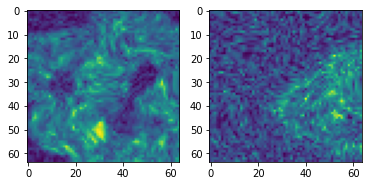

In [51]:
#specify subvolume size and volume source
volSize = (1,5,64, 64)
coord = (0,0,0,0)

zarrdir = '/mnt/shared/celltracking/data/cho/01.zarr'
raw = gp.ArrayKey('raw')
raw_shift = gp.ArrayKey('raw_shift')

# create "pipeline" consisting only of a data source


#Augmentations=

# chose a random source (i.e., sample) from the above
#random_location = gp.RandomLocation()

pipeline_paired = (gp.ZarrSource(
    zarrdir,  # the zarr container
    {raw_shift: 'raw', raw: 'raw'},  # which dataset to associate to the array key
    {raw_shift: gp.ArraySpec(voxel_size=(1,1,1,1), interpolatable=True), raw:gp.ArraySpec(voxel_size=(1,1,1,1), interpolatable=True)}  # meta-information
    )+ gp.Normalize(raw)+gp.Normalize(raw_shift)+ 
    gp.Pad(raw_shift, None) + 
    gp.Pad(raw, None) + gp.IntensityAugment(
    raw,
    scale_min=0.9,
    scale_max=1.1,
    shift_min=-0.1,
    shift_max=0.1,
    ) + gp.NoiseAugment(raw, mode="gaussian")) + gp.IntensityAugment(
    raw_shift,
    scale_min=0.9,
    scale_max=1.1,
    shift_min=-0.1,
    shift_max=0.1,
    ) + gp.NoiseAugment(raw_shift, mode="gaussian") + getPaired(raw,raw_shift,tracks,paired=True) + gp.ElasticAugment(
    [2,10,10],
    [0,2,2],
    [0,0*math.pi/2.0],
    prob_slip=0.05,
    prob_shift=0.05,
    max_misalign=25) + gp.SimpleAugment(transpose_only=[2, 3], mirror_only=[])



pipeline_unpaired = (gp.ZarrSource(
    zarrdir,  # the zarr container
    {raw_shift: 'raw', raw: 'raw'},  # which dataset to associate to the array key
    {raw_shift: gp.ArraySpec(voxel_size=(1,1,1,1), interpolatable=True), raw:gp.ArraySpec(voxel_size=(1,1,1,1), interpolatable=True)}  # meta-information
    )+ gp.Normalize(raw)+gp.Normalize(raw_shift)+ 
    gp.Pad(raw_shift, None) + 
    gp.Pad(raw, None) + gp.IntensityAugment(
    raw,
    scale_min=0.9,
    scale_max=1.1,
    shift_min=-0.1,
    shift_max=0.1,
    ) + gp.NoiseAugment(raw, mode="gaussian") + gp.IntensityAugment(
    raw_shift,
    scale_min=0.9,
    scale_max=1.1,
    shift_min=-0.1,
    shift_max=0.1,
    ) + gp.NoiseAugment(raw_shift, mode="gaussian")) + getPaired(raw,raw_shift,tracks,paired=False)  + gp.ElasticAugment(
    [2,10,10],
    [0,2,2],
    [0,0*math.pi/2.0],
    prob_slip=0.05,
    prob_shift=0.05,
    max_misalign=25) + gp.SimpleAugment(transpose_only=[2, 3], mirror_only=[]) 


# specify request
request = gp.BatchRequest()
request[raw] = gp.Roi(coord, volSize)
request[raw_shift] = gp.Roi(coord, volSize)

gp.ArraySpec()
# build the pipeline...
with gp.build(pipeline_unpaired):

  # ...and request a batch
  batch = pipeline_unpaired.request_batch(request)
  
#show the content of the batch
#print(f"batch returned: {batch}")

# plot first slice of volume
fig, axs = plt.subplots(1,2)
axs[0].imshow(np.flipud(batch[raw].data[0,0,:,:]))
axs[1].imshow(np.flipud(batch[raw_shift].data[0,0,:,:]))



In [31]:
# provide path to zarr directory
zarrdir = '/mnt/shared/celltracking/data/cho/01.zarr'

data = zarr.open(zarrdir)
loader = []

## Define Augmentation pipeline

In [32]:
# provide path to zarr directory
#zarrdir = '/mnt/shared/celltracking/data/cho/01.zarr'

# pre-selected volumes from cho dataset
coord_paired = ((0,0,80, 175),(1,0,80, 180))
coord_unpaired = ((0,0,80, 175),(1,0,92, 232))

# specify subvolume size and volume source
volSize = (1,5,64, 64)
coord = coord_paired[0]

# declare arrays to use in the pipeline
key ='raw'
raw = gp.ArrayKey(key)

# create "pipeline" consisting only of a data source
source = gp.ZarrSource(
    zarrdir,  # the zarr container
    {raw: key},  # which dataset to associate to the array key
    {raw: gp.ArraySpec(interpolatable=True, voxel_size = (1,1,1,1))}  # meta-information
)
pipeline = source

# specify request paired
request_vol1p = gp.BatchRequest()
request_vol2p = gp.BatchRequest()
request_vol1p[raw] = gp.Roi(coord_paired[0], volSize)
request_vol2p[raw] = gp.Roi(coord_paired[1], volSize)

# specify request unpaired
request_vol1u = gp.BatchRequest()
request_vol2u = gp.BatchRequest()
request_vol1u[raw] = gp.Roi(coord_unpaired[0], volSize)
request_vol2u[raw] = gp.Roi(coord_unpaired[1], volSize)

# build the pipeline
with gp.build(pipeline):
    batch_vol1p = pipeline.request_batch(request_vol1p)
    batch_vol2p = pipeline.request_batch(request_vol2p)
    batch_vol1u = pipeline.request_batch(request_vol1u)
    batch_vol2u = pipeline.request_batch(request_vol2u)

# Augmentations

In [33]:
#Augmentations=

# chose a random source (i.e., sample) from the above
#random_location = gp.RandomLocation()

# elastically deform the batch
Elastic_augment=gp.ElasticAugment(
    [2,10,10],
    [0,2,2],
    [0,0*math.pi/2.0],
    prob_slip=0.05,
    prob_shift=0.05,
    max_misalign=25)

# apply transpose and mirror augmentations
# Simple_augment=gp.SimpleAugment(transpose_only=[2, 3], mirror_only=[]) 
Simple_augment=gp.SimpleAugment(transpose_only=[], mirror_only=[])

# scale and shift the intensity of the raw array
Intensity_augment=gp.IntensityAugment(
    raw,
    scale_min=0.9,
    scale_max=1.1,
    shift_min=-0.1,
    shift_max=0.1,
    )

Noise_augment = gp.NoiseAugment(raw, mode="gaussian")

pipeline = (
    source + gp.Normalize(raw)+
            Intensity_augment+Elastic_augment + Simple_augment + Noise_augment
           )

# build the pipeline
with gp.build(pipeline):
    for x in range(10):
        batch_vol1p = pipeline.request_batch(request_vol1p)
        batch_vol2p = pipeline.request_batch(request_vol2p)
        batch_vol1u = pipeline.request_batch(request_vol1u)
        batch_vol2u = pipeline.request_batch(request_vol2u)
        # show the content of the batch
        #print(f"batch returned: {batch}")

        # plot first slice of volume

        # fig, (ax1, ax2) = plt.subplots(1, 2)
        # ax1.imshow(np.flipud(batch_vol1p[raw].data[0,1,:,:]))
        # ax2.imshow(np.flipud(batch_vol2p[raw].data[0,1,:,:]))
        # plt.show()


In [34]:
# specify request 
#plt.imshow(np.flipud(batch_vol1[raw].data[0,0,:,:]))

# request = gp.BatchRequest()
# request[raw] = gp.Roi(coord, volSize)

# with gp.build(pipeline):
#     batch_vol1_aug = pipeline.request_batch(request)
#     batch_vol2_aug = pipeline.request_batch(request)

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
# ax1.imshow(np.flipud(batch_vol1[raw].data[0,0,:,:]))
# ax1.set_title('input vol1')
# ax2.imshow(np.flipud(batch_vol1_aug[raw].data[0,0,:,:]))
# ax2.set_title('aug vol1')
# ax3.imshow(np.flipud(batch_vol2[raw].data[0,0,:,:]))
# ax3.set_title('input vol2')
# ax4.imshow(np.flipud(batch_vol2_aug[raw].data[0,0,:,:]))
# ax4.set_title('aug vol2')

# Define the Model

In [35]:
class Vgg3D(torch.nn.Module):

    def __init__(self, input_size, output_classes, downsample_factors, fmaps=12):

        super(Vgg3D, self).__init__()

        self.input_size = input_size
        self.downsample_factors = downsample_factors
        self.output_classes = 2

        current_fmaps, h, w, d = tuple(input_size)
        current_size = (h, w,d)

        features = []
        for i in range(len(downsample_factors)):

            features += [
                torch.nn.Conv3d(current_fmaps,fmaps,kernel_size=3,padding=1),
                torch.nn.BatchNorm3d(fmaps),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv3d(fmaps,fmaps,kernel_size=3,padding=1),
                torch.nn.BatchNorm3d(fmaps),
                torch.nn.ReLU(inplace=True),
                torch.nn.MaxPool3d(downsample_factors[i])
            ]

            current_fmaps = fmaps
            fmaps *= 2

            size = tuple(
                int(c/d)
                for c, d in zip(current_size, downsample_factors[i]))
            check = (
                s*d == c
                for s, d, c in zip(size, downsample_factors[i], current_size))
            assert all(check), \
                "Can not downsample %s by chosen downsample factor" % \
                (current_size,)
            current_size = size

        self.features = torch.nn.Sequential(*features)

        classifier = [
            torch.nn.Linear(current_size[0] *current_size[1]*current_size[2] *current_fmaps,4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Linear(4096,4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Linear(4096,output_classes)
        ]

        self.classifier = torch.nn.Sequential(*classifier)
    
    def forward(self, raw):

        # add a channel dimension to raw
        # shape = tuple(raw.shape)
        # raw = raw.reshape(shape[0], 1, shape[1], shape[2])
        
        # compute features
        f = self.features(raw)
        f = f.view(f.size(0), -1)
        
        # classify
        y = self.classifier(f)

        return y

# Loss Functions

We'll probably need to test some different loss functions. List some here:
Contrastive loss
cosine similarity
triplet loss



In [36]:
class ContrastiveLoss(nn.Module):
    "Contrastive loss function"

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2)
            + (label)
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive

In [37]:
input_size = (1, 64, 64, 5)
downsample_factors =[(2, 2, 1), (2, 2, 1), (2, 2, 1), (2, 2, 1)];
output_classes = 12

# create the model to train
model = Vgg3D(input_size, output_classes,  downsample_factors = downsample_factors)
model = model.to(device)

summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 12, 64, 64, 5]             336
       BatchNorm3d-2        [-1, 12, 64, 64, 5]              24
              ReLU-3        [-1, 12, 64, 64, 5]               0
            Conv3d-4        [-1, 12, 64, 64, 5]           3,900
       BatchNorm3d-5        [-1, 12, 64, 64, 5]              24
              ReLU-6        [-1, 12, 64, 64, 5]               0
         MaxPool3d-7        [-1, 12, 32, 32, 5]               0
            Conv3d-8        [-1, 24, 32, 32, 5]           7,800
       BatchNorm3d-9        [-1, 24, 32, 32, 5]              48
             ReLU-10        [-1, 24, 32, 32, 5]               0
           Conv3d-11        [-1, 24, 32, 32, 5]          15,576
      BatchNorm3d-12        [-1, 24, 32, 32, 5]              48
             ReLU-13        [-1, 24, 32, 32, 5]               0
        MaxPool3d-14        [-1, 24, 16

In [38]:
#Training length
epochs = 2000

#loss_function = torch.nn.BCELoss()
loss_function = torch.nn.CosineEmbeddingLoss()
#loss_function = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)

# Training Test

# Implementing the Siamese Network

The above training is just to test if the VGG model works for 3D data. Here, the training will take two pairs of images and calculate the loss from both pairs of images.

In [47]:
#%tensorboard --logdir models

logger = SummaryWriter()
%tensorboard --logdir runs

In [52]:
from tqdm import tqdm

def train(tb_logger = None, log_image_interval = 10):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
        
    loss=[] 
    counter=[]
    with gp.build(pipeline_paired), gp.build(pipeline_unpaired):
        for epoch in tqdm(range(epochs)):
            epoch_loss = 0
            epoch_loss_pos = 0
            epoch_loss_neg = 0
            for x in range(100):
                unpaired = pipeline_unpaired.request_batch(request)
                yu = -1
                
                paired = pipeline_paired.request_batch(request)
                yp = 1
                
                unpaired1 = unpaired[raw].data[:,:,:,:]
                unpaired2 = unpaired[raw_shift].data[:,:,:,:]
                paired1 = paired[raw].data[:,:,:,:]
                paired2 = paired[raw_shift].data[:,:,:,:]
                
                unpaired1 = np.reshape(unpaired1, (1,64, 64, 5))
                unpaired2 = np.reshape(unpaired2, (1,64, 64, 5))
                paired1 = np.reshape(paired1, (1,64, 64, 5))
                paired2 = np.reshape(paired2, (1,64, 64, 5))
                
                unpaired1 = np.expand_dims(unpaired1, axis =0)
                unpaired2 = np.expand_dims(unpaired2, axis=0)
                paired1 = np.expand_dims(paired1, axis =0)
                paired2 = np.expand_dims(paired2, axis=0)

                unpaired1 = torch.from_numpy(unpaired1).to(device).float()
                unpaired2 = torch.from_numpy(unpaired2).to(device).float()
                yu = torch.from_numpy(np.array([yu])).to(device).float()
                
                paired1 = torch.from_numpy(paired1).to(device).float()
                paired2 = torch.from_numpy(paired2).to(device).float() 
                yp = torch.from_numpy(np.array([yp])).to(device).float()

                optimizer.zero_grad()
                
                predp1 = model(unpaired1)
                predp2 = model(unpaired2)
                predu1 = model(paired1)
                predu2 = model(paired2)
                # print(model(unpaired1).shape)
                # print(predp1.shape)

                #loss = loss_function(pred, y)

                loss_contrastivep = loss_function(predp1,predp2,yp)
                loss_contrastiveu = loss_function(predu1,predu2,yu)

                loss_contrastivep.backward()
                loss_contrastiveu.backward()
                optimizer.step()    
                epoch_loss_pos += loss_contrastivep
                epoch_loss_neg += loss_contrastiveu
                epoch_loss += loss_contrastivep + loss_contrastiveu
                
                if tb_logger is not None:
                    step = epoch * 100 + x
                    tb_logger.add_scalar(
                        tag="positive_loss", scalar_value=epoch_loss_pos.item(), global_step=step
                    )
                    tb_logger.add_scalar(
                        tag="negative_loss", scalar_value=epoch_loss_neg.item(), global_step=step
                    )
                    tb_logger.add_scalar(
                        tag="total_loss", scalar_value=epoch_loss.item(), global_step = step
                    )
                    # check if we log images in this iteration
                    # if step % log_image_interval == 0:
                    #     tb_logger.add_images(
                    #         tag="in_unpaired1", img_tensor=unpaired1.to("cpu"), global_step=step
                    #     )
                    #     tb_logger.add_images(
                    #         tag="in_unpaired2", img_tensor=unpaired2.to("cpu"), global_step=step
                    #     )
                    #     tb_logger.add_images(
                    #         tag="in_paired1", img_tensor=paired1.to("cpu"), global_step=step
                    #     )
                    #     tb_logger.add_images(
                    #         tag="in_paired2", img_tensor=paired2.to("cpu"), global_step=step
                    #     )


            print(f"epoch {epoch}, total_loss = {epoch_loss}, positive_loss={epoch_loss_pos}, negative_loss={epoch_loss_neg}")
        
    return model

model = train(tb_logger = logger)

  0%|          | 0/2000 [00:00<?, ?it/s]

(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64,

  0%|          | 1/2000 [05:47<192:42:39, 347.05s/it]

(1, 5, 64, 64)
epoch 0, total_loss = 100.64949035644531, positive_loss=13.240337371826172, negative_loss=87.40918731689453
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 

  0%|          | 2/2000 [11:00<181:42:56, 327.42s/it]

(1, 5, 64, 64)
epoch 1, total_loss = 99.9430923461914, positive_loss=10.302929878234863, negative_loss=89.64015197753906
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64

  0%|          | 3/2000 [17:27<196:43:22, 354.63s/it]

(1, 5, 64, 64)
epoch 2, total_loss = 100.10045623779297, positive_loss=10.534195899963379, negative_loss=89.56625366210938
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 

  0%|          | 4/2000 [22:31<185:30:55, 334.60s/it]

(1, 5, 64, 64)
epoch 3, total_loss = 100.5341796875, positive_loss=8.549531936645508, negative_loss=91.9846420288086
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)
(1, 5, 64, 64)


  0%|          | 4/2000 [24:45<205:54:04, 371.36s/it]


KeyboardInterrupt: 

# Tracking / Linear Assignment